# <center><u>Projet VI - Notebook 1 - Le prétraitement</u></center>

___
L'objectif de cette mission est d'évaluer la faisabilité d'un moteur de classification automatique des articles sur une place de marché e-commerce.    
Actuellement, l'attribution des catégories est réalisée mannuellement par les vendeurs, ce qui peut être imprécis.    
L'objectif est de simplifié et d'améliorer cette tache en utilisant des desciptions textuelles et des images de produits pour attribuer automatiquement une catégorie.    

Cette étude repose sur plusieurs étapes clés :
- Le prétraitement des données, l'extraction de features à partir des desciptions textuelles et des images.    
- Une visualisation des regroupement pour analyser la faisabilité d'un tel système, une évaluation des performances via des technique de clustering et de classification.    

Cette démarche va permettre de poser les bases d'une solution automatisée pour garantir une expérience fluide aux utilisateurs.
___

In [1]:
# Installation des packages :
#pip install pandas numpy matplotlib seaborn missingno
#%pip install --upgrade tensorflow tensorflow-hub

In [2]:
# Importation des librairies
import sys # Python v3.12.4
import os
import re
import string
import pandas as pd # v2.2.3
import numpy as np # v2.0.2
import matplotlib # v3.9.2
import matplotlib.pyplot as plt
import seaborn as sns # v0.13.2
import missingno as msno # v0.5.2
import plotly # v5.24.1
import plotly.express as px
import nltk # v3.9.1
import cv2 # v4.10.0
import time
import tensorflow as tf # v2.18.0
import tensorflow_hub as hub
import shutil

from IPython.display import Image, display, HTML
from PIL import Image
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")
stop=set(stopwords.words("english"))
from collections import Counter, defaultdict
from wordcloud import WordCloud
from sklearn import manifold, preprocessing, cluster, metrics, decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer, TFAutoModel, logging
from os import listdir
from matplotlib.image import imread
from tensorflow.keras import Input, Model, Sequential, applications, layers, preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.layers import RandomFlip, Dense, Dropout, RandomRotation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions, preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\icema\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Information sur l'environnement virtuel :
print("Version des librairies :")
print("Python        : " + sys.version)
print("Pandas        : " + pd.__version__)
print("NumPy         : " + np.version.__version__)
print("Matplotlib    : " + matplotlib.__version__)
print("Seaborn       : " + sns.__version__)
print("missingno     : " + msno.__version__)
print("plotly        : " + plotly.__version__)
print("nltk          : " + nltk.__version__)
print("cv2           : " + cv2.__version__)
print("TensorFlow    : " + tf.__version__)

Version des librairies :
Python        : 3.12.4 (tags/v3.12.4:8e8a4ba, Jun  6 2024, 19:30:16) [MSC v.1940 64 bit (AMD64)]
Pandas        : 2.2.3
NumPy         : 2.0.2
Matplotlib    : 3.9.2
Seaborn       : 0.13.2
missingno     : 0.5.2
plotly        : 5.24.1
nltk          : 3.9.1
cv2           : 4.10.0
TensorFlow    : 2.18.0


In [4]:
# Paramètre d'affichage :
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

# style de titres
style = {"family": "Arial",
        "color":  'darkblue',
        "weight": "bold",
        "size": 15,
        }

## Fonction Utilitaires

In [5]:
def extract_categories(category):
    category = category.split("['", 1)[-1].split("']", 1)[0]
    cat = category.split(" >> ")
    cat += ["None"] * (3 - len(cat))
    return cat[:3]

def detail_categories(dataframe):
    df_cats = dataframe["product_category_tree"].apply(extract_categories).tolist()
    dataframe[["cat_niv_1", "cat_niv_2", "cat_niv_3"]] = df_cats
    return dataframe.drop(["product_category_tree"], axis=1)

def caractere_count(text):
    carc=0
    for car in text.split():
        carc +=len(car)
    return carc

# Le tokenizer utilisera une expression régulière pour extraire uniquement les mots (lettres, chiffres, underscore).
tokenizer = RegexpTokenizer(r"\w+")

# Ensemble des mots vides en anglais
stop = set(stopwords.words("english"))

# Initialisation du stemmer et du lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Convertir le texte en minuscules
    text = str(text).lower()

    # Supprimer les chiffres, les éventuelles balises HTML ou liens URL
    text = re.sub(r"\d+|\[.*?\]|https?://\S+|www\.\S+", "", text)

    # Supprimer les emojis et symboles divers
    text = re.sub(r"["
                u"\U0001F600-\U0001F64F"   # Emoticônes
                u"\U0001F300-\U0001F5FF"   # Symboles et pictogrammes
                u"\U0001F680-\U0001F6FF"   # Symboles de transport/cartes
                u"\U0001F1E0-\U0001F1FF"   # Drapeaux (iOS)
                u"\u200d"                  # Jointure à largeur zéro
                u"\u2640-\u2642"           # Symboles de genre
                u"\U000024C2-\U0001F251"   # Caractères enfermés
                "]+", "", text)

    # Supprimer la ponctuation
    text = re.sub("[" + re.escape(string.punctuation) + "]", "", text)

    # Tokeniser le texte
    tokens = tokenizer.tokenize(text)

    # Retirer les mots vides (stopwords)
    tokens = [token for token in tokens if token not in stop and token.strip() != ""]

    # Appliquer le stemming
    tokens_stemmed = [stemmer.stem(token) for token in tokens]

    # Appliquer la lemmatisation
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens_stemmed]

    # Reconstruire le texte nettoyé
    return " ".join(tokens_lemmatized)


def fc_ari(features) :
    time1 = time.time()

    # Déterminer le nombre de clusters
    labels=len(n_clusters)

    tsne = manifold.TSNE(n_components=2, learning_rate=200, init='random', random_state=77)

    X_tsne = tsne.fit_transform(features)

    # Détermination des clusters à partir des données après Tsne
    cls = cluster.KMeans(n_clusters=labels, random_state=77)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_feature, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "Temps d'exécution : ", time2)

    return ARI, X_tsne, cls.labels_

def visuel_tsne(X_tsne, y_true, labels, ARI) :
    fig = plt.figure(figsize=(15,6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_feature)
    ax.legend(handles=scatter.legend_elements()[0], labels=n_clusters, loc="best", title="Categorie")
    plt.title("Catégories réelles")

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels)
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title("Clusters")

    plt.show()
    print("ARI : ", ARI)

# Importation des données

In [6]:
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

# Augmenter la limite de pixels
Image.MAX_IMAGE_PIXELS = None # a utiliser uniquement si les images sont fiables
images_folder = r"C:\\Users\\icema\\OpenClassrooms\\AI_Engineer\\.venv6\\Images"
images = [Image.open(os.path.join(images_folder, file)) for file in os.listdir(images_folder) if file.endswith(".jpg")]
image_filenames = [file for file in os.listdir(images_folder) if file.endswith(".jpg")]

# Exploration des données

In [7]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [8]:
data.tail()

uniq_id            crawl_timestamp  \
1045  958f54f4c46b53c8a0a9b8167d9140bc  2015-12-01 10:15:43 +0000   
1046  fd6cbcc22efb6b761bd564c28928483c  2015-12-01 10:15:43 +0000   
1047  5912e037d12774bb73a2048f35a00009  2015-12-01 10:15:43 +0000   
1048  c3edc504d1b4f0ba6224fa53a43a7ad6  2015-12-01 10:15:43 +0000   
1049  f2f027ad6a6df617c9f125173da71e44  2015-12-01 10:15:43 +0000   

                                            product_url  \
1045  http://www.flipkart.com/oren-empower-extra-lar...   
1046  http://www.flipkart.com/wallmantra-large-vinyl...   
1047  http://www.flipkart.com/uberlyfe-extra-large-p...   
1048  http://www.flipkart.com/wallmantra-medium-viny...   
1049  http://www.flipkart.com/uberlyfe-large-vinyl-s...   

                                           product_name  \
1045     Oren Empower Extra Large Self Adhesive Sticker   
1046             Wallmantra Large Vinyl Sticker Sticker   
1047  Uberlyfe Extra Large Pigmented Polyvinyl Films...   
1048            Wallmantra Medium Vinyl Sticker Sticker   
1049                       Uberlyfe Large Vinyl Sticker   

                                  product_category_tree               pid  \
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE88ZGTX65GH4V   
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZD5GDCVQ   
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE5UVGW2JWVWCT   
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIEC889ZGFD3RCE   
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...  STIE2ZEPACRQJKH7   

      retail_price  discounted_price                                 image  \
1045        1399.0             999.0  958f54f4c46b53c8a0a9b8167d9140bc.jpg   
1046        4930.0            1896.0  fd6cbcc22efb6b761bd564c28928483c.jpg   
1047        4500.0            1449.0  5912e037d12774bb73a2048f35a00009.jpg   
1048        3465.0            1333.0  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg   
1049        1190.0             595.0  f2f027ad6a6df617c9f125173da71e44.jpg   

      is_FK_Advantage_product  \
1045                    False   
1046                    False   
1047                    False   
1048                    False   
1049                    False   

                                            description       product_rating  \
1045  Oren Empower Extra Large Self Adhesive Sticker...  No rating available   
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...  No rating available   
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...  No rating available   
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...  No rating available   
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...                    4   

           overall_rating         brand  \
1045  No rating available  Oren Empower   
1046  No rating available    Wallmantra   
1047  No rating available      Uberlyfe   
1048  No rating available    Wallmantra   
1049                    4      Uberlyfe   

                                 product_specifications  
1045  {"product_specification"=>[{"key"=>"Number of ...  
1046  {"product_specification"=>[{"key"=>"Number of ...  
1047  {"product_specification"=>[{"key"=>"Number of ...  
1048  {"product_specification"=>[{"key"=>"Number of ...  
1049  {"product_specification"=>[{"key"=>"Sales Pack...

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [10]:
nb_lignes, nb_colonnes = data.shape
type_colonnes = data.dtypes.value_counts()
print(f"Nombre de lignes : {nb_lignes}")
print(f"Nombre de colonnes : {nb_colonnes}")
print(f"Type des colonnes : \n{type_colonnes}")

Nombre de lignes : 1050
Nombre de colonnes : 15
Type des colonnes : 
object     12
float64     2
bool        1
Name: count, dtype: int64


In [11]:
data.describe()

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

<Axes: >

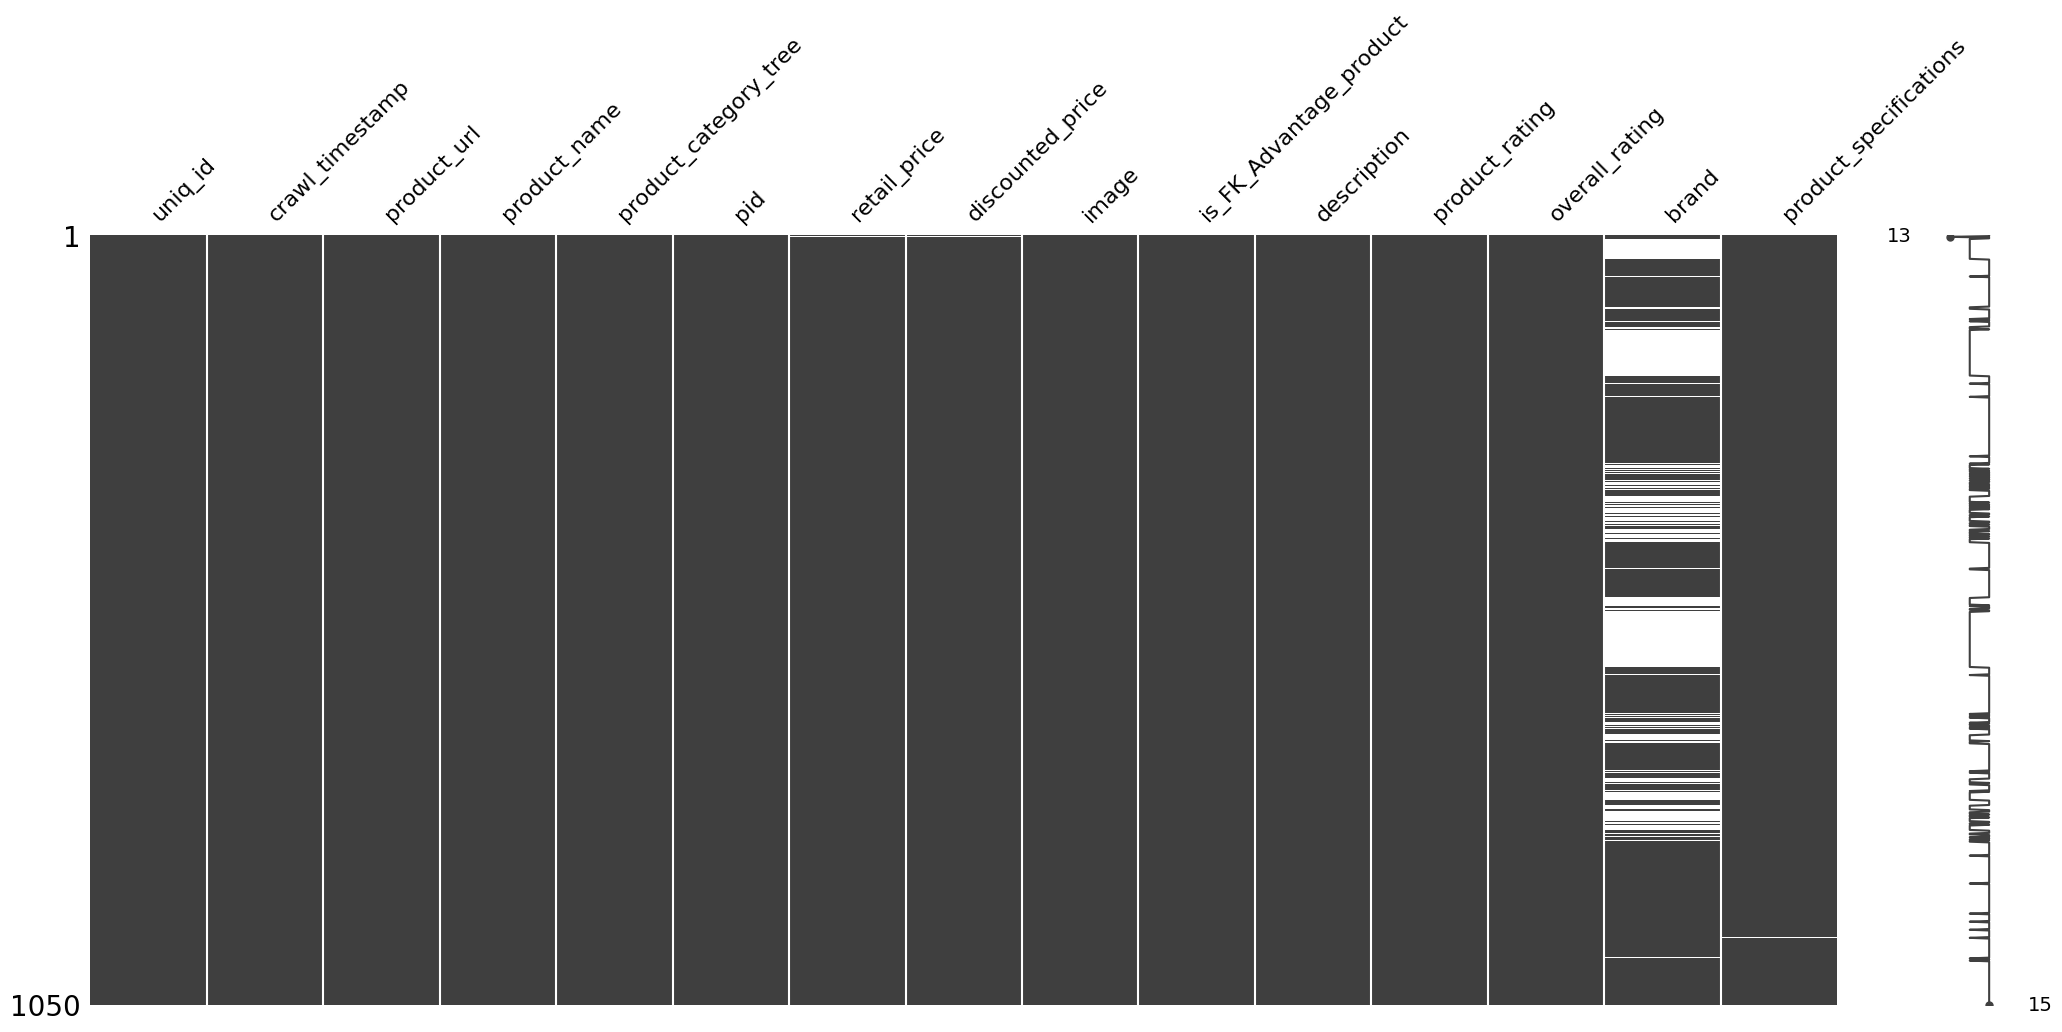

In [12]:
msno.matrix(data)

In [13]:
# Nombre d'images dans le dossiers
len([file for file in os.listdir(images_folder) if file.endswith(".jpg")])

1050

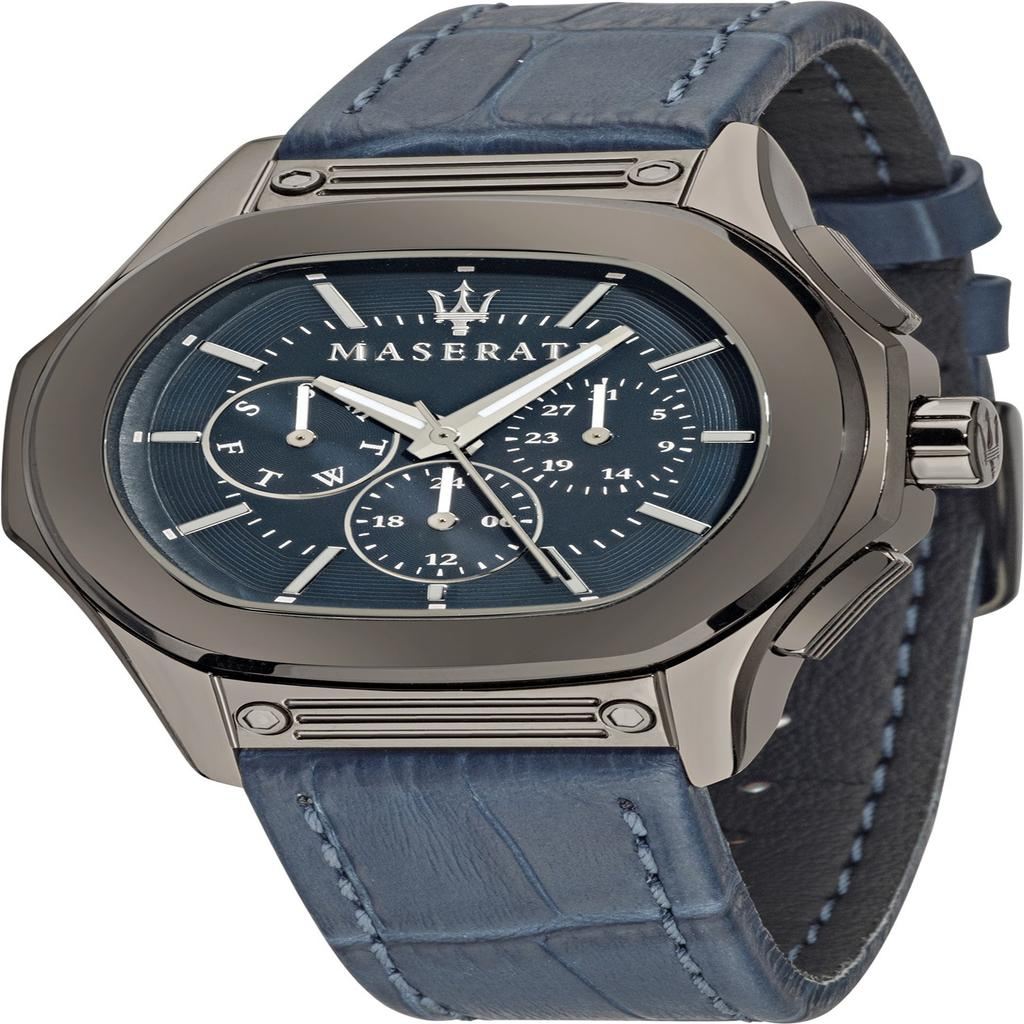

In [14]:
from IPython.display import Image

# Affichage d'une image provenant du dossiers
select_image1 = image_filenames[571]
image_path1 = os.path.join(images_folder, select_image1)
display(Image(filename=image_path1))

In [15]:
from PIL import Image

# Taille de l'image
select_nb_image = Image.open("C:\\Users\\icema\\OpenClassrooms\\AI_Engineer\\.venv6\\Images\\893aa5ed55f7cff2eccea7758d7a86bd.jpg")
w, h = select_nb_image.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

Largeur : 1024 px, hauteur : 1024 px


___
Nous avons un fichier csv avec 1050 lignes et un dossier d'image avec ce même nombre.
___

## Observation de la colonne "retail_price"

Text(0.5, 1.0, 'Représentation des catégories')

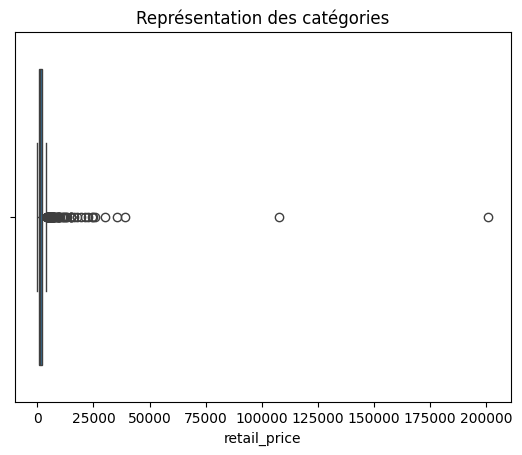

In [16]:
sns.boxplot(x = data["retail_price"], data = data)
plt.title("Représentation des catégories")

In [17]:
# Visualisation de produits supérieur à 20000
data[data["retail_price"]>=20000]

uniq_id            crawl_timestamp  \
5    893aa5ed55f7cff2eccea7758d7a86bd  2015-12-04 07:25:36 +0000   
9    710ed5f2393a4b9e8823aa0029f71f93  2015-12-04 07:25:36 +0000   
11   08452abdadb3db1e686b94a9c52fc7b6  2015-12-04 07:25:36 +0000   
90   6ae332e2bafd23267caedfcc4453257c  2016-01-04 00:20:04 +0000   
318  fd2716d0e5dd7ffc367ca4dd9f97aaa0  2015-12-01 06:13:00 +0000   
329  cb0afa31d9ca796908fde019cd64044d  2015-12-01 06:13:00 +0000   
437  b6c339777814451815fe7950fd4c8536  2016-06-16 08:51:06 +0000   
604  85aec4bf3185da7ebcc45003429cbfe2  2016-01-07 04:32:43 +0000   
605  bcb8e456728013a90ba66ab3b1b783ad  2016-01-07 04:32:43 +0000   
606  afc829d45be38102afaa20f4bce2f627  2016-03-12 14:25:06 +0000   

                                           product_url  \
5    http://www.flipkart.com/maserati-time-r8851116...   
9    http://www.flipkart.com/tag-heuer-cau1116-ba08...   
11   http://www.flipkart.com/cartier-w6701005-analo...   
90   http://www.flipkart.com/exotic-india-adi-buddh...   
318  http://www.flipkart.com/asus-wireless-ac2400-d...   
329  http://www.flipkart.com/asus-rt-ac68u-dual-ban...   
437  http://www.flipkart.com/homeedge-solid-wood-ki...   
604  http://www.flipkart.com/hp-15-ac116tx-notebook...   
605  http://www.flipkart.com/hp-15-ac121tu-notebook...   
606  http://www.flipkart.com/soulful-threads-red-th...   

                                          product_name  \
5    Maserati Time R8851116001 Analog Watch  - For ...   
9    TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...   
11      Cartier W6701005 Analog Watch  - For Boys, Men   
90   Exotic India Adi Buddha Vajrasattva Showpiece ...   
318      Asus Wireless AC2400 Dual-band Gigabit Router   
329  Asus RT-AC68U Dual-band Wireless-AC1900 Gigabi...   
437                       HomeEdge Solid Wood King Bed   
604  HP 15-ac116TX (Notebook) (Core i3 (5th Gen)/ 4...   
605  HP 15-ac121tu (Notebook) (Core i3 (5th Gen)/ 4...   
606  Soulful Threads Red Thread Aari Embroidered Bl...   

                                 product_category_tree               pid  \
5    ["Watches >> Wrist Watches >> Maserati Time Wr...  WATEAYAHJ8CUCAYM   
9    ["Watches >> Wrist Watches >> TAG Heuer Wrist ...  WATEA6UGFGKZKDJC   
11   ["Watches >> Wrist Watches >> Cartier Wrist Wa...  WATEAK8SE2RUK7GM   
90   ["Home Decor & Festive Needs >> Showpieces >> ...  SHIE3QDHGXSE3PYE   
318  ["Computers >> Network Components >> Routers >...  RTREYTY2TMVNXZG4   
329  ["Computers >> Network Components >> Routers >...  RTRDRDPR9JHCSBGH   
437  ["Beauty and Personal Care >> Health Care >> H...  BDDEH93ZEEZY7CHM   
604             ["Computers >> Laptops >> HP Laptops"]  COMEAZ945RHFFGUS   
605             ["Computers >> Laptops >> HP Laptops"]  COMEAZ94HWYQTZHZ   
606  ["Beauty and Personal Care >> Makeup >> Vanity...  VANEGPA7ZKGT2UUH   

     retail_price  discounted_price                                 image  \
5         24400.0           24400.0  893aa5ed55f7cff2eccea7758d7a86bd.jpg   
9        107750.0          107750.0  710ed5f2393a4b9e8823aa0029f71f93.jpg   
11       201000.0          201000.0  08452abdadb3db1e686b94a9c52fc7b6.jpg   
90        22525.0           21800.0  6ae332e2bafd23267caedfcc4453257c.jpg   
318       29990.0           21290.0  fd2716d0e5dd7ffc367ca4dd9f97aaa0.jpg   
329       25000.0           13390.0  cb0afa31d9ca796908fde019cd64044d.jpg   
437       25499.0           18799.0  b6c339777814451815fe7950fd4c8536.jpg   
604       38890.0           38890.0  85aec4bf3185da7ebcc45003429cbfe2.jpg   
605       35390.0           35390.0  bcb8e456728013a90ba66ab3b1b783ad.jpg   
606       21125.0            1700.0  afc829d45be38102afaa20f4bce2f627.jpg   

     is_FK_Advantage_product  \
5                      False   
9                      False   
11                     False   
90                     False   
318                    False   
329                    False   
437                    False   
604                     True   
605                     True  

___
Les tarifs sont exprimé en roupies indiennes (INR, symbole : ₹), monnaie officielle de l'inde
___

## Recherche des catégories principales de produits

7
cat_niv_1
["Home Furnishing               150
["Baby Care                     150
["Watches                       150
["Home Decor & Festive Needs    150
["Kitchen & Dining              150
["Beauty and Personal Care      150
["Computers                     150
Name: count, dtype: int64


Text(0.5, 1.0, 'Représentation des catégories')

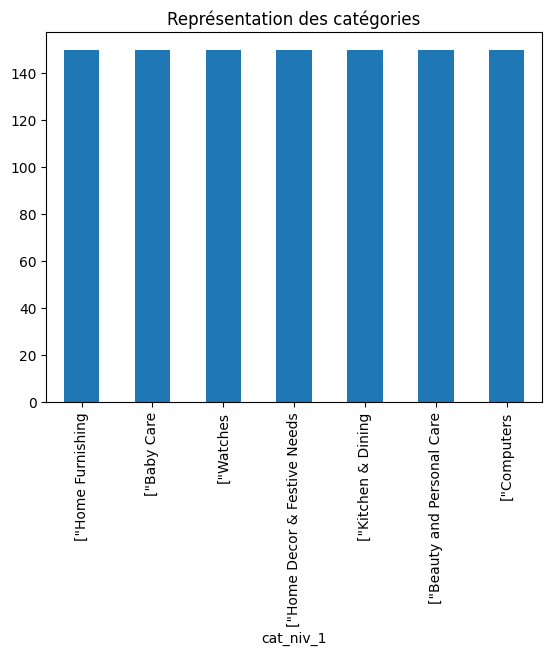

In [18]:
data = detail_categories(data)

print(data["cat_niv_1"].nunique())

print(data["cat_niv_1"].value_counts())

data["cat_niv_1"].value_counts().head(7).plot(kind = "bar")
plt.title("Représentation des catégories")

63
cat_niv_2
Wrist Watches                        149
Laptop Accessories                    87
Infant Wear                           84
Coffee Mugs                           74
Showpieces                            71
Bed Linen                             65
Fragrances                            65
Network Components                    49
Cookware                              27
Table Decor & Handicrafts             27
Combos and Kits                       24
Wall Decor & Clocks                   22
Bath Linen                            21
Curtains & Accessories                19
Makeup                                18
Body and Skin Care                    15
Baby & Kids Gifts                     15
Baby Bedding                          15
Kitchen & Dining Linen                14
Kitchen Tools                         14
Baby Bath & Skin                      14
Decorative Lighting & Lamps           14
Containers & Bottles                  13
Cushions, Pillows & Covers            13
Hai

Text(0.5, 1.0, 'Représentation des catégories')

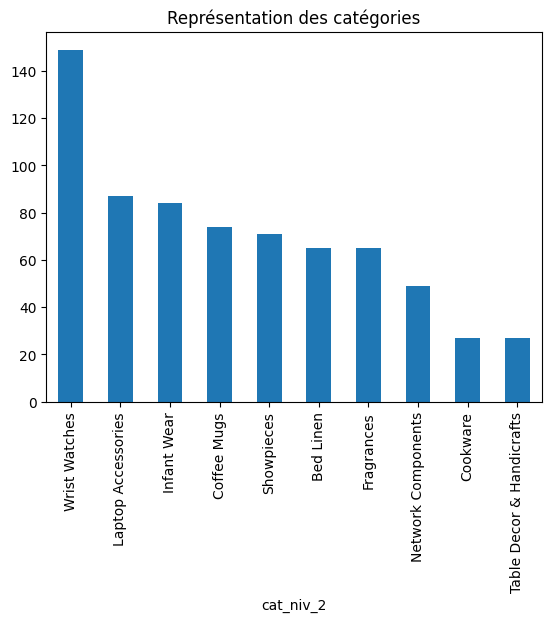

In [19]:
print(data["cat_niv_2"].nunique())

print(data["cat_niv_2"].value_counts())

data["cat_niv_2"].value_counts().head(10).plot(kind = "bar")
plt.title("Représentation des catégories")

247
cat_niv_3
Deodorants                         65
Blankets, Quilts & Dohars"]        56
Routers                            49
Baby Girls' Clothes                49
USB Gadgets                        38
                                   ..
Kitchen Tool Sets                   1
RAMs                                1
Medicines & Treatment               1
Shampoos                            1
Medical Equipment & Accessories     1
Name: count, Length: 247, dtype: int64


Text(0.5, 1.0, 'Représentation des catégories')

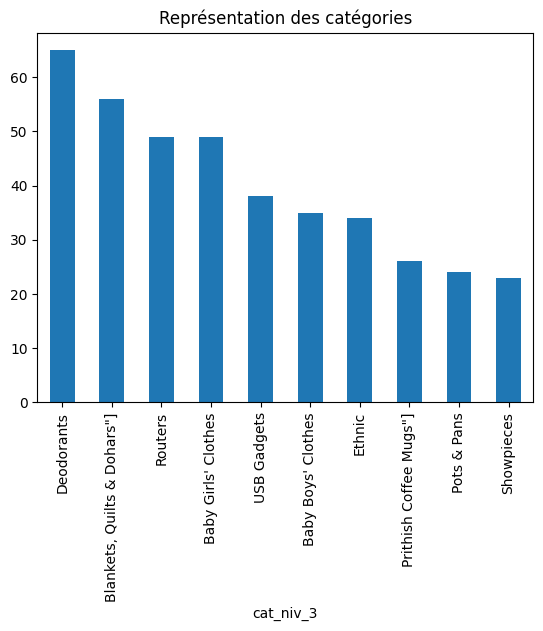

In [20]:
print(data["cat_niv_3"].nunique())

print(data["cat_niv_3"].value_counts())

# Analyse de notre top 10 des produits

data["cat_niv_3"].value_counts().head(10).plot(kind = "bar")
plt.title("Représentation des catégories")

In [21]:
# Comptage du nombre de mots
data["text_len"]=data["description"].apply(lambda x:len(x.split()))

# Comptage du nombre de caractères
data["text_char_len"]=data["description"].apply(caractere_count)

data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name               pid  \
0  Elegance Polyester Multicolor Abstract Eyelet ...  CRNEG7BKMFFYHQ8Z   
1                         Sathiyas Cotton Bath Towel  BTWEGFZHGBXPHZUH   
2                Eurospa Cotton Terry Face Towel Set  BTWEG6SHXTDB2A2Y   
3  SANTOSH ROYAL FASHION Cotton Printed King size...  BDSEJT9UQWHDUBH4   
4  Jaipur Print Cotton Floral King sized Double B...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications          cat_niv_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  ["Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        ["Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        ["Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  ["Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  ["Home Furnishing   

                cat_niv_2         cat_niv_3  text_len  text_char_len  
0  Curtains & Accessories          Curtains       230           1191  
1        Baby Bath & Skin  Baby Bath Towels        74            371  
2        Baby Bath & Skin  Baby Bath Towels       215           1044  
3               Bed Linen         Bedsheets       145            714  
4               Bed Linen         Bedsheets       214            984

In [22]:
# Création du corpus
corpus=[]

for x in data["description"].str.split():
    for i in x:
        corpus.append(i)

Le "corpus" sera une liste de tout les mots extraits de la colonne description.

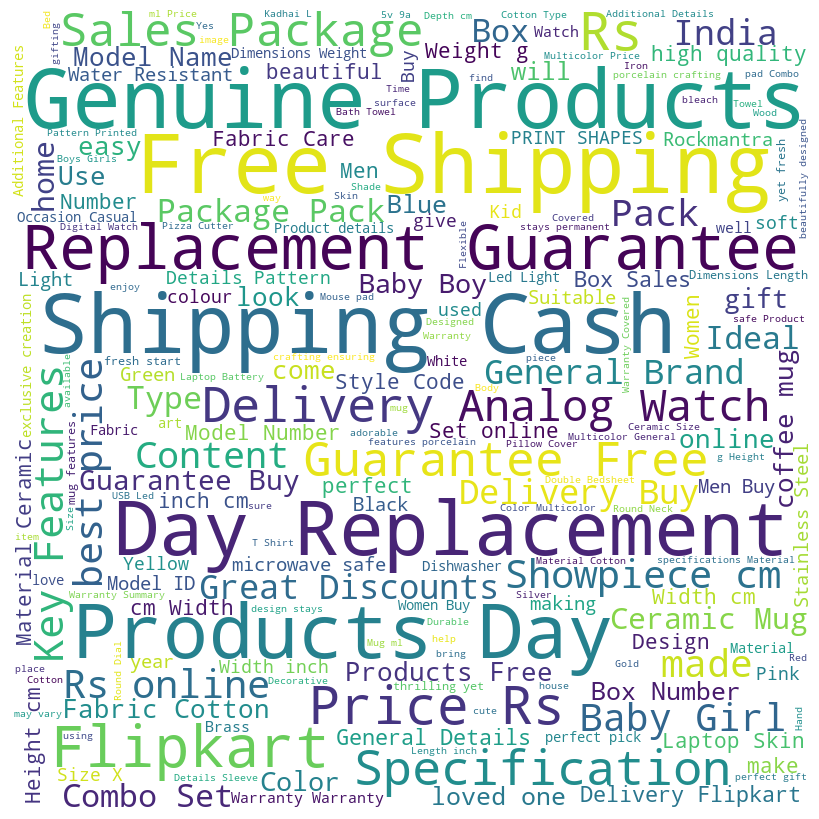

In [23]:
# Concaténation de tous les mots dans le corpus
text = ' '.join(corpus)

# Création de l'objet WordCloud
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ="white", 
                min_font_size = 10).generate(text)

# Affiche le WordCloud
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

Plus la taille des mots est grande plus ces mots sont présent dans le corpus

In [24]:
# Visualisation des mots les plus fréquent après l'exclusion des stopwords
dic=defaultdict(int)
for word in corpus:
    if word not in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:30] 
x,y=zip(*top)
fig=px.bar(x=x,y=y)
fig.update_layout(title={
        "text": "Liste des mots les plus utilisés pour le StopWords",
        "y":0.95,
        "x":0.5,
        "xanchor": "center",
        "yanchor": "top"},xaxis_title="Mots utilisés",yaxis_title="Frequency")

In [25]:
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:30]
x,y=zip(*top)
fig=px.bar(x=x,y=y)
fig.update_layout(title={
        "text": "Liste des mots communs les plus utilisés pour le StopWords",
        "y":0.95,
        "x":0.5,
        "xanchor": "center",
        "yanchor": "top"},xaxis_title="Words",yaxis_title="Frequency")

In [26]:
data["clean_text"]=data["description"].apply(clean_text)
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name               pid  \
0  Elegance Polyester Multicolor Abstract Eyelet ...  CRNEG7BKMFFYHQ8Z   
1                         Sathiyas Cotton Bath Towel  BTWEGFZHGBXPHZUH   
2                Eurospa Cotton Terry Face Towel Set  BTWEG6SHXTDB2A2Y   
3  SANTOSH ROYAL FASHION Cotton Printed King size...  BDSEJT9UQWHDUBH4   
4  Jaipur Print Cotton Floral King sized Double B...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications          cat_niv_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  ["Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        ["Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        ["Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  ["Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  ["Home Furnishing   

                cat_niv_2         cat_niv_3  text_len  text_char_len  \
0  Curtains & Accessories          Curtains       230           1191   
1        Baby Bath & Skin  Baby Bath Towels        74            371   
2        Baby Bath & Skin  Baby Bath Towels       215           1044   
3               Bed Linen         Bedsheets       145            714   
4               Bed Linen         Bedsheets       214            984   

                                          clean_text  
0  key featur eleg polyest multicolor abstract ey...  
1  specif sathiya cotton bath towel bath towel re...  
2  key featur eurospa cotton terri face towel set...  
3  key featur santosh royal fashion cotton print ...  
4  key featur jaipur print cotton floral king siz...

In [27]:
corpus=[]

for x in data["clean_text"].str.split():
    for i in x:
        corpus.append(i)
dic=defaultdict(int)
for word in corpus:
    if word not in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:30]
x,y=zip(*top)
fig=px.bar(x=x,y=y)
fig.update_layout(title={
        "text": "Liste des mots les plus utilisés pour le StopWords",
        "y":0.95,
        "x":0.5,
        "xanchor": "center",
        "yanchor": "top"},xaxis_title="Mots utilisés",yaxis_title="Frequency")

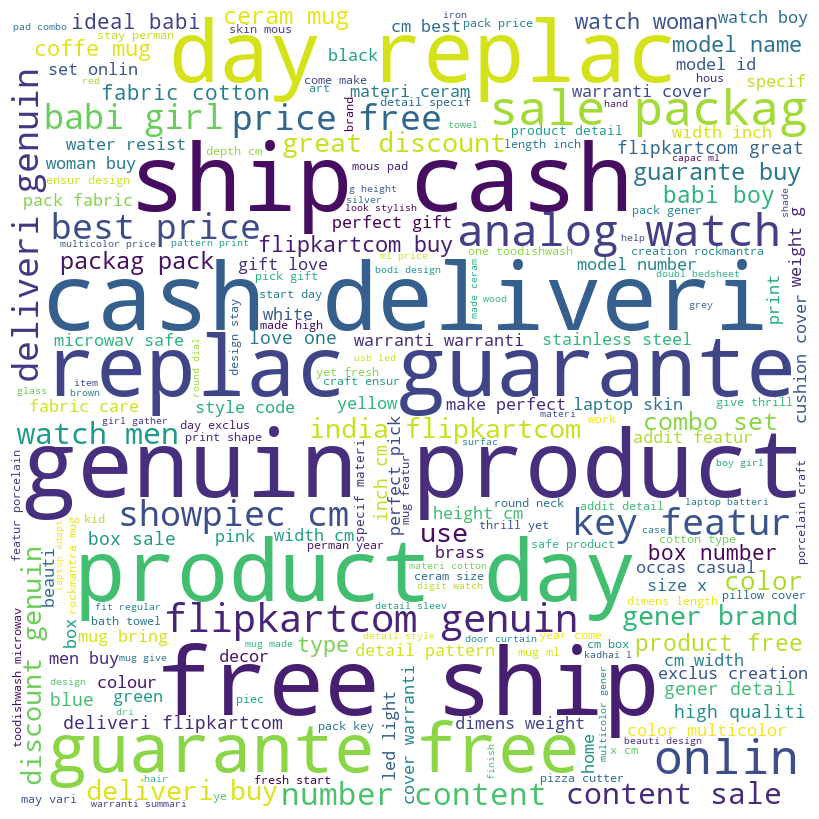

In [28]:
# # Concaténation de tous les mots dans le corpus pour la colonne "clean_text"
text = ' '.join(data["clean_text"].str.lower())

# Création de l'objet WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ="white",
                min_font_size = 10).generate(text)

# Affiche le WordCloud
plt.figure(figsize = (8, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [29]:
# Comptage des mots
data["text_len_final"]=data["clean_text"].apply(lambda x:len(x.split()))

In [30]:
# Comptage du nombre de caractères
data["text_char_len_final"]=data["clean_text"].apply(caractere_count)
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name               pid  \
0  Elegance Polyester Multicolor Abstract Eyelet ...  CRNEG7BKMFFYHQ8Z   
1                         Sathiyas Cotton Bath Towel  BTWEGFZHGBXPHZUH   
2                Eurospa Cotton Terry Face Towel Set  BTWEG6SHXTDB2A2Y   
3  SANTOSH ROYAL FASHION Cotton Printed King size...  BDSEJT9UQWHDUBH4   
4  Jaipur Print Cotton Floral King sized Double B...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications          cat_niv_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  ["Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        ["Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        ["Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  ["Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  ["Home Furnishing   

                cat_niv_2         cat_niv_3  text_len  text_char_len  \
0  Curtains & Accessories          Curtains       230           1191   
1        Baby Bath & Skin  Baby Bath Towels        74            371   
2        Baby Bath & Skin  Baby Bath Towels       215           1044   
3               Bed Linen         Bedsheets       145            714   
4               Bed Linen         Bedsheets       214            984   

                                          clean_text  text_len_final  \
0  key featur eleg polyest multicolor abstract ey...             149   
1  specif sathiya cotton bath towel bath towel re...              62   
2  key featur eurospa cotton terri face towel set...             151   
3  key featur santosh royal fashion cotton print ...             113   
4  key featur jaipur print cotton floral king siz...             151   

   text_char_len_final  
0                  841  
1                  303  
2                  747  
3                  579  
4                  753

In [31]:
print(data["description"].iloc[0])

Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you 

In [32]:
print(data["clean_text"].iloc[0])

key featur eleg polyest multicolor abstract eyelet door curtain floral curtaineleg polyest multicolor abstract eyelet door curtain cm height pack price r curtain enhanc look interiorsthi curtain made high qualiti polyest fabricit featur eyelet style stitch metal ringit make room environ romant lovingthi curtain ant wrinkl anti shrinkag eleg apparanceg home bright modernist appeal design surreal attent sure steal heart contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlightspecif eleg polyest multicolor abstract eyelet door curtain cm height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id duster color multicolor dimens length cm box number content sale packag pack sale packag curtain bodi design materi polyest


In [33]:
data.describe()

retail_price  discounted_price     text_len  text_char_len  \
count    1049.000000       1049.000000  1050.000000    1050.000000   
mean     2186.197331       1584.527169    76.202857     391.204762   
std      7639.229411       7475.099680    74.851233     377.304570   
min        35.000000         35.000000    13.000000      63.000000   
25%       555.000000        340.000000    30.000000     161.000000   
50%       999.000000        600.000000    44.000000     231.500000   
75%      1999.000000       1199.000000    94.000000     475.000000   
max    201000.000000     201000.000000   587.000000    2902.000000   

       text_len_final  text_char_len_final  
count     1050.000000          1050.000000  
mean        52.539048           272.465714  
std         47.861961           252.395991  
min         12.000000            50.000000  
25%         22.000000           110.250000  
50%         33.000000           167.500000  
75%         70.750000           354.000000  
max        367.000000          1964.000000

In [34]:
# Colonnes à supprimer
data.drop(columns = ["uniq_id", "crawl_timestamp", "product_url", "product_name", "pid",
    "retail_price", "discounted_price","is_FK_Advantage_product",
    "description", "product_rating", "overall_rating", "brand",
    "product_specifications", "cat_niv_2", "cat_niv_3",
    "text_len", "text_char_len", "text_len_final",
    "text_char_len_final"], inplace = True)

data.head(5)

image          cat_niv_1  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  ["Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        ["Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        ["Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  ["Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  ["Home Furnishing   

                                          clean_text  
0  key featur eleg polyest multicolor abstract ey...  
1  specif sathiya cotton bath towel bath towel re...  
2  key featur eurospa cotton terri face towel set...  
3  key featur santosh royal fashion cotton print ...  
4  key featur jaipur print cotton floral king siz...

In [35]:
from sklearn import preprocessing

# Labelisation des catégories de produits
encode = preprocessing.LabelEncoder()
data["cat_label"] = encode.fit_transform(np.array(data["cat_niv_1"]))

data.head()

image          cat_niv_1  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  ["Home Furnishing   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg        ["Baby Care   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg        ["Baby Care   
3  d4684dcdc759dd9cdf41504698d737d8.jpg  ["Home Furnishing   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg  ["Home Furnishing   

                                          clean_text  cat_label  
0  key featur eleg polyest multicolor abstract ey...          4  
1  specif sathiya cotton bath towel bath towel re...          0  
2  key featur eurospa cotton terri face towel set...          0  
3  key featur santosh royal fashion cotton print ...          4  
4  key featur jaipur print cotton floral king siz...          4

<Axes: >

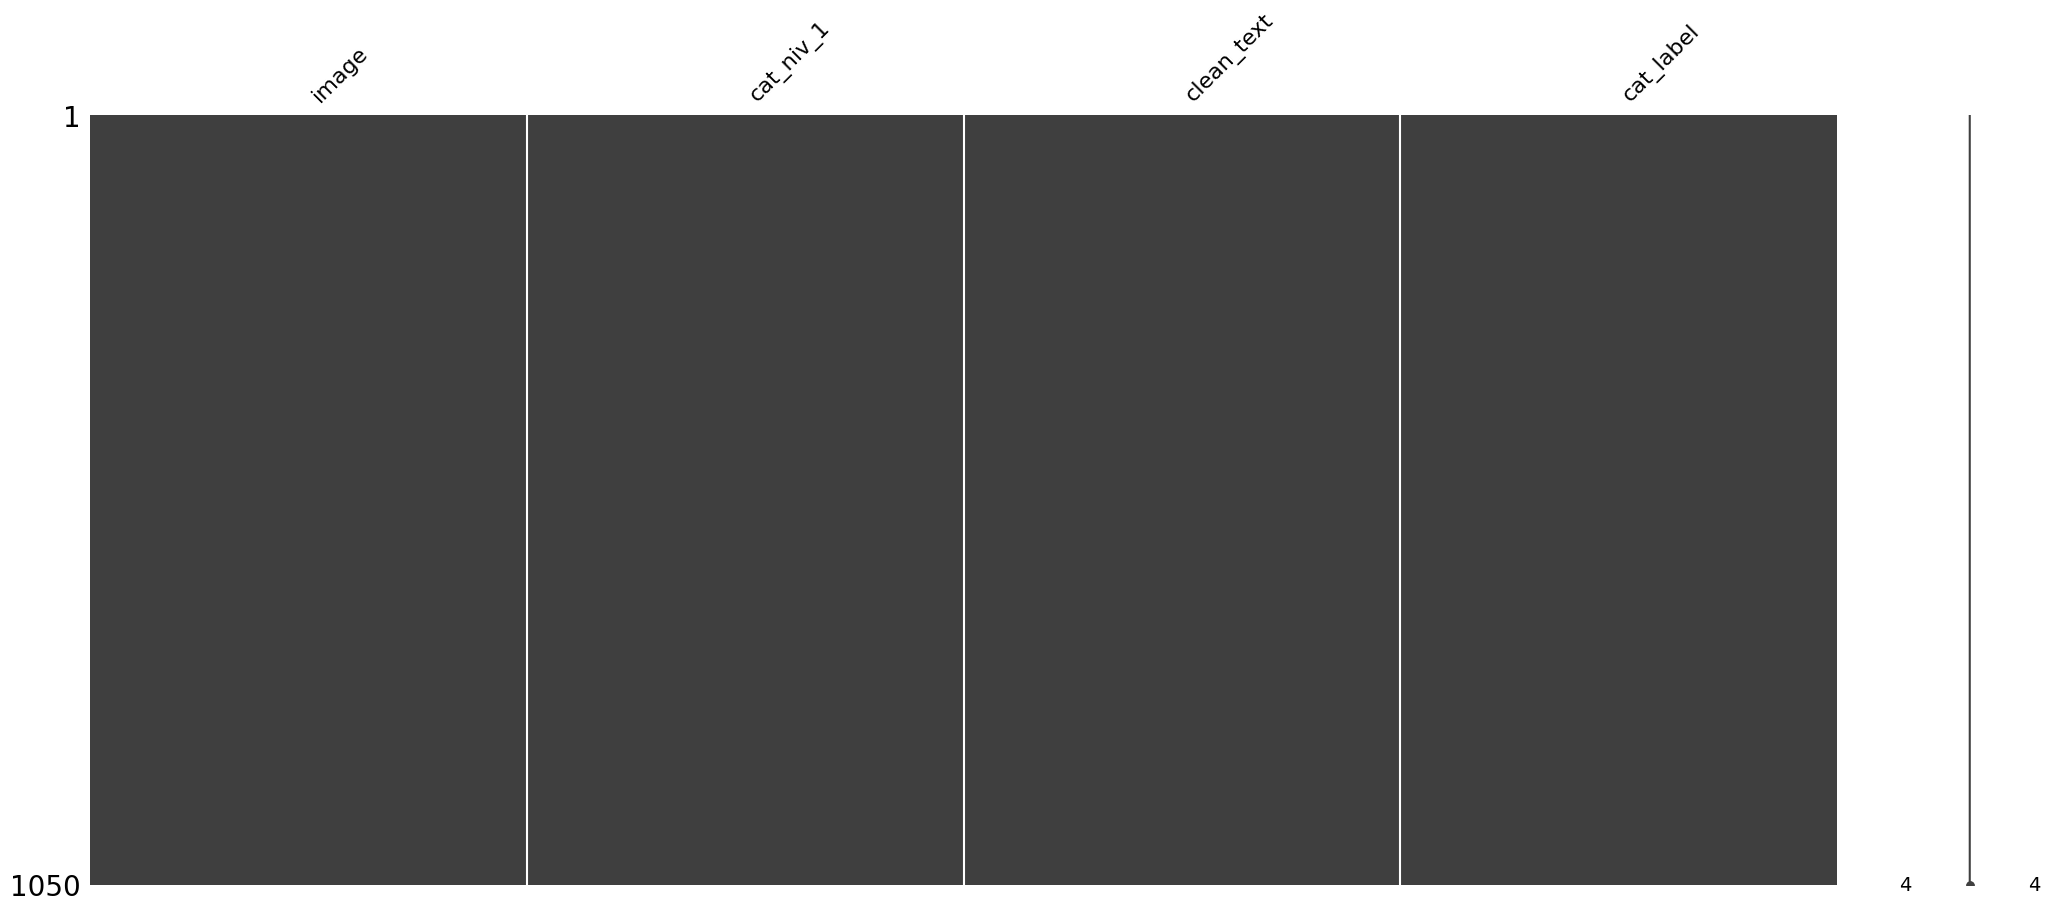

In [36]:
msno.matrix(data)

## Word2Vec

In [37]:
# Création du nombre de catégories pour les clusters
n_clusters = list(data.cat_niv_1.unique())

# Création de la feature
y_feature = data["cat_label"]

# Création des méthodes Count et tfifd vectorizer
vector = CountVectorizer()
vectorizer = TfidfVectorizer()

feat = "clean_text"
vect_fit = vector.fit(data[feat])
tf_vectorizer_fit = vectorizer.fit(data[feat])

vect_transform = vector.transform(data[feat])
tf_vectorizer_transform = vectorizer.transform(data[feat])

print(tf_vectorizer_transform.shape)

(1050, 4550)


Utilisation de la méthode CountVectorizer : 
-----------------
ARI :  0.4239 Temps d'exécution :  2.0


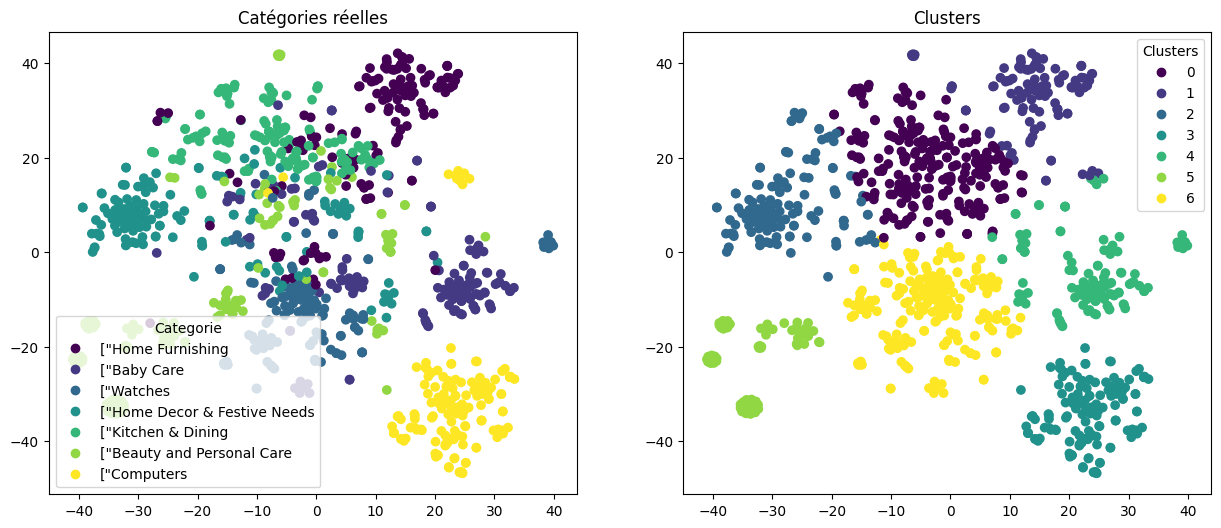

ARI :  0.4239


In [38]:
print("Utilisation de la méthode CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = fc_ari(vect_transform)
visuel_tsne(X_tsne, y_feature, labels, ARI)

Utilisation de la méthode Tf-idf : 
--------
ARI :  0.418 Temps d'exécution :  1.0


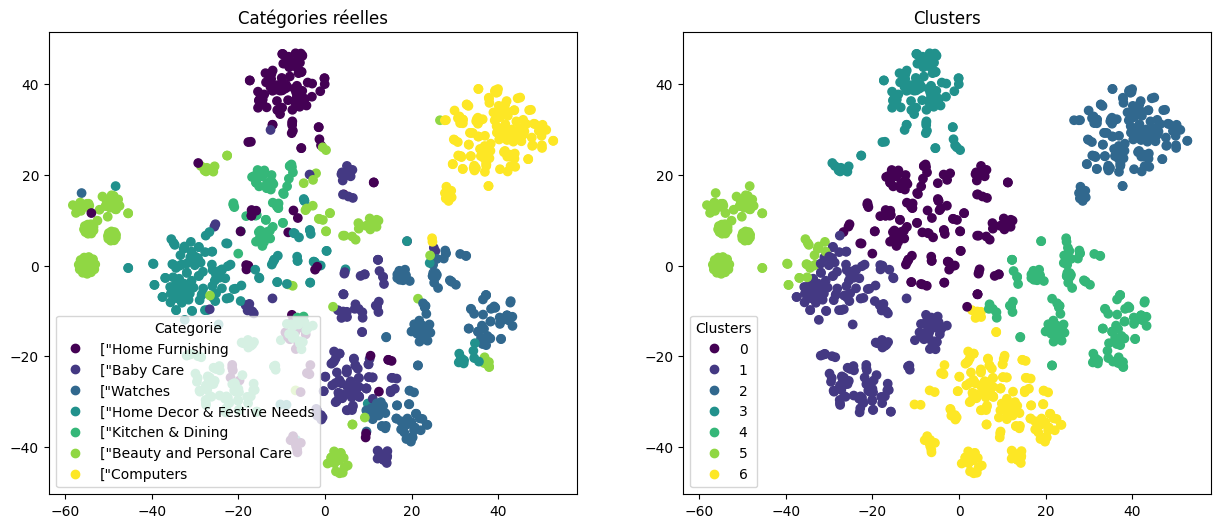

ARI :  0.418


In [39]:
print("Utilisation de la méthode Tf-idf : ")
print("--------")
ARI, X_tsne, labels = fc_ari(tf_vectorizer_transform)
visuel_tsne(X_tsne, y_feature, labels, ARI)

## BERT

In [40]:
# Chargement du modèle et du tokenizer avec gestion explicite des poids inutilisés
model_type = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
model = TFAutoModel.from_pretrained(model_type, from_pt=True)

# Prétraitement des textes
batch_size = 64
max_length = 256
sentences = data["clean_text"].values

input_ids, token_type_ids, attention_mask = [], [], []
for sent in sentences:
    bert_inp = bert_tokenizer.encode_plus(
        sent,
        add_special_tokens=True,
        max_length=max_length,
        padding="max_length",
        return_attention_mask=True,
        return_token_type_ids=True,
        truncation=True,
        return_tensors="tf"
    )
    input_ids.append(bert_inp["input_ids"][0])
    token_type_ids.append(bert_inp["token_type_ids"][0])
    attention_mask.append(bert_inp["attention_mask"][0])

input_ids = np.asarray(input_ids)
token_type_ids = np.asarray(token_type_ids)
attention_mask = np.asarray(attention_mask)

# Passage dans le modèle
text_preprocessed = {
    "input_ids": input_ids,
    "attention_mask": attention_mask,
    "token_type_ids": token_type_ids
}
outputs = model(text_preprocessed)
features_bert = np.array(outputs[0]).mean(axis=1)

print("Embeddings calculés avec succès :", features_bert.shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Embeddings calculés avec succès : (1050, 768)


Embeddings calculés : [[-9.62742418e-02  1.02346614e-01  6.40509486e-01 ...  1.24160178e-01
  -1.09179780e-01  4.02545705e-02]
 [ 7.20616430e-02 -1.03572764e-01  3.95110309e-01 ... -1.49532929e-01
  -4.16020751e-02  5.31153642e-02]
 [-1.35949507e-01 -3.08883190e-02  5.33544660e-01 ... -9.37194973e-02
  -1.60465837e-01  1.00859299e-01]
 ...
 [-3.56016122e-02 -2.69382328e-01  3.62939298e-01 ...  5.15917502e-02
  -1.18889511e-01 -1.59932971e-01]
 [ 2.48891418e-04 -1.79304630e-01  3.20797712e-01 ...  1.57941595e-01
  -2.53098272e-02 -1.34844825e-01]
 [ 6.89471373e-03 -3.43086004e-01  3.71764362e-01 ...  1.04539372e-01
  -6.71731681e-02 -1.21427484e-01]]
ARI :  0.3064 Temps d'exécution :  1.0


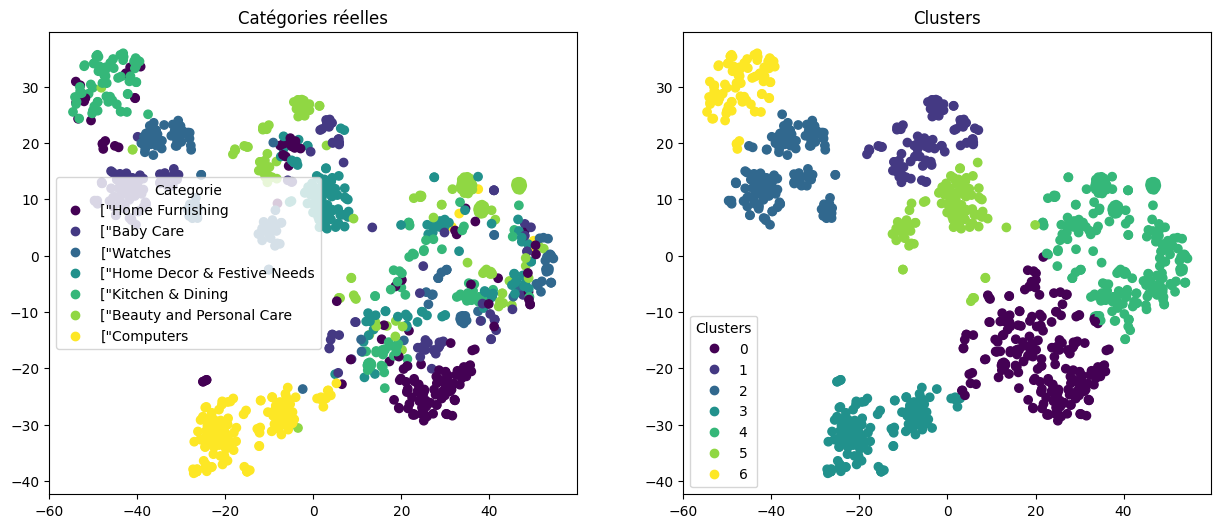

ARI :  0.3064


In [41]:
# Résultat final pour BERT
print("Embeddings calculés :", features_bert)

ARI, X_tsne, labels = fc_ari(features_bert)

visuel_tsne(X_tsne, y_feature, labels, ARI)

## USE

In [42]:
# Définir un répertoire de cache
os.environ["TFHUB_CACHE_DIR"] = os.path.expanduser("~/tmp/tfhub_modules")

# Créer le répertoire cache
tf.io.gfile.makedirs(os.environ["TFHUB_CACHE_DIR"])

# Charger le modèle Universal Sentence Encoder
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Les phrases à encoder
sentences = data["clean_text"].values

# Chronométrage
start_time = time.time()

# Passage des phrases dans le modèle pour générer les embeddings
features_use = use_model(sentences).numpy()

# Chronométrage terminé
execution_time = np.round(time.time() - start_time, 2)

# Afficher les résultats
print(f"Temps de traitement : {execution_time}s")
print(f"Embeddings calculés : {features_use.shape}")

Temps de traitement : 0.3s
Embeddings calculés : (1050, 512)


ARI :  0.4111 Temps d'exécution :  1.0


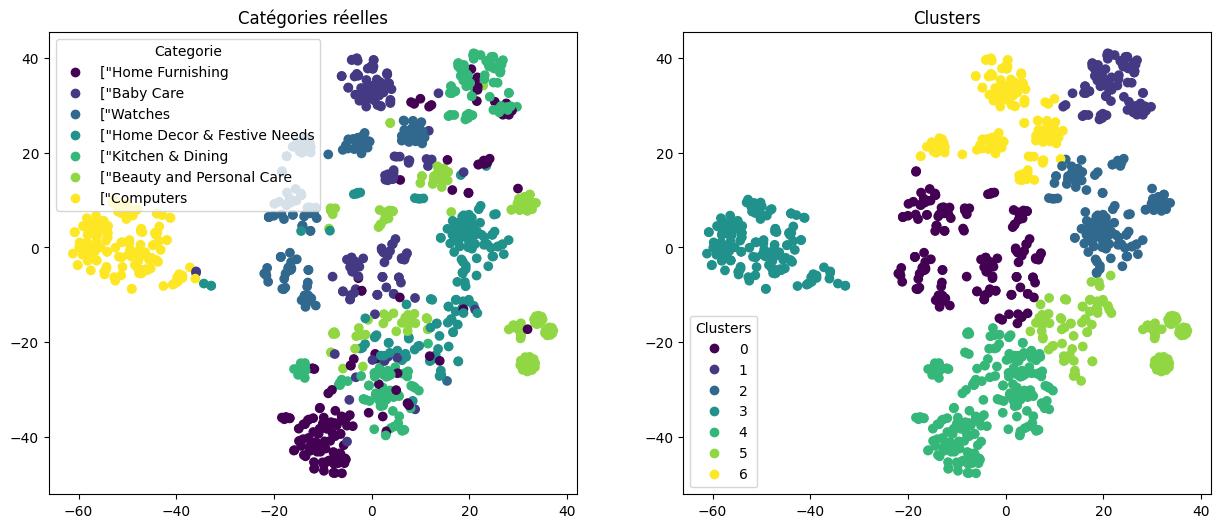

ARI :  0.4111


In [43]:
ARI, X_tsne, labels = fc_ari(features_use)

visuel_tsne(X_tsne, y_feature, labels, ARI)

## Export CSV

In [44]:
data.to_csv("data_image.csv",header=True,index=False)

# Traitement de l'image

In [45]:
# Définir le chemin et vérifier les images
path = "C:\\Users\\icema\\OpenClassrooms\\AI_Engineer\\.venv6\\Images\\"
list_photos = [file for file in os.listdir(path)]
print(len(list_photos))

# Copy du DF
data_image = data[["image", "cat_label"]].copy()

# Ajouter le chemin au nom des fichiers dans la colonne 'image'
data_image["image"] = data_image["image"].apply(lambda x: path + str(x))

1050


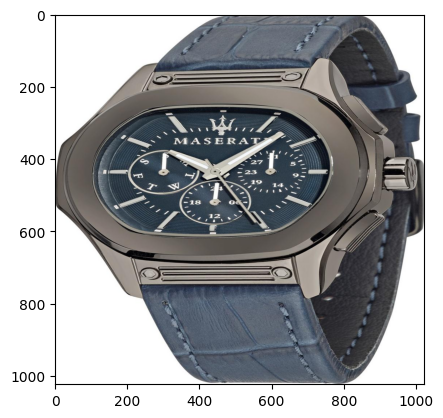

In [46]:
image = imread(path+list_photos[571])
plt.imshow(image)

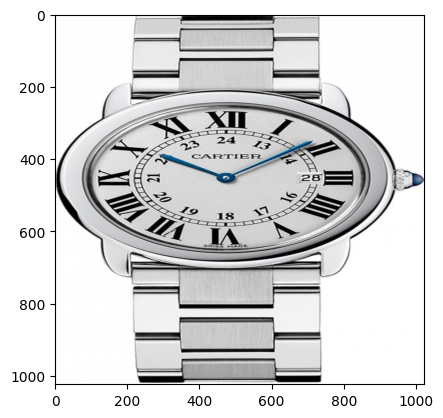

In [47]:
image = imread(path+list_photos[31])
plt.imshow(image)

["Home Furnishing


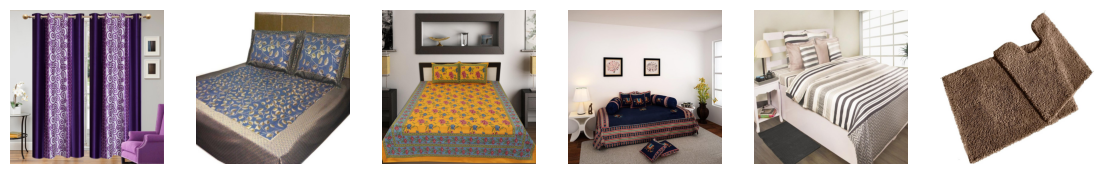

["Baby Care


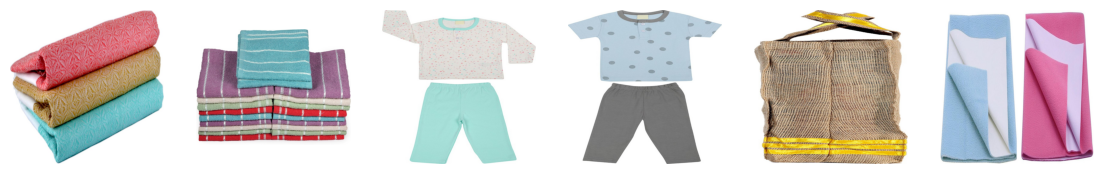

["Watches


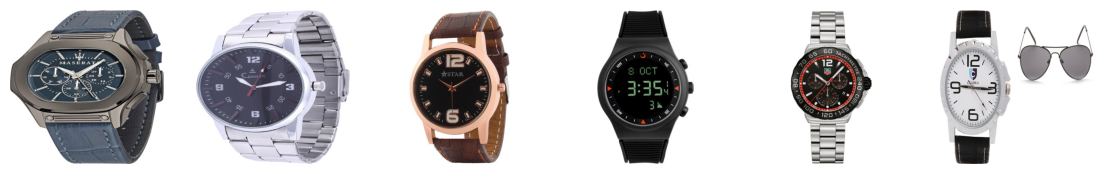

["Home Decor & Festive Needs


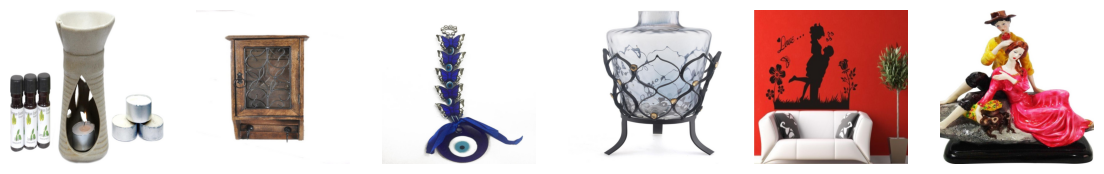

["Kitchen & Dining


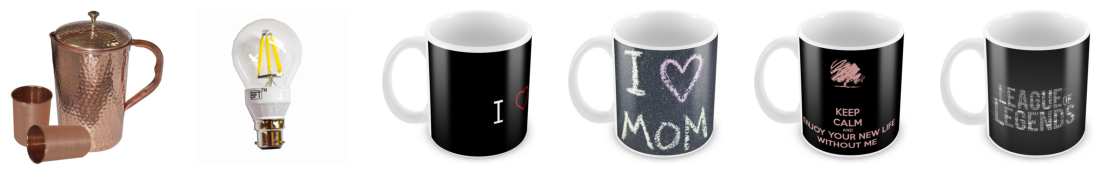

["Beauty and Personal Care


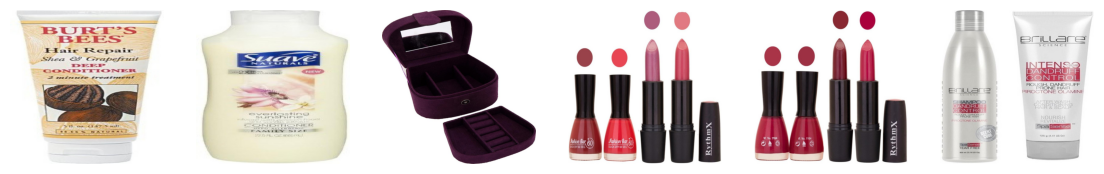

["Computers


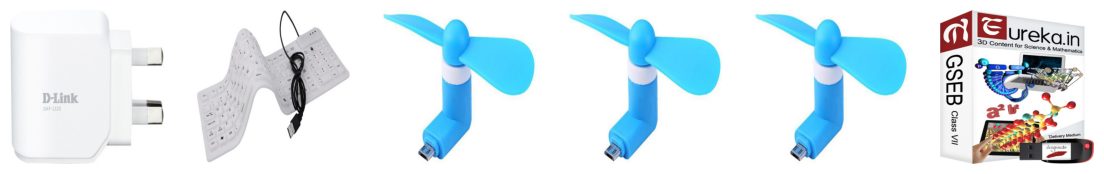

In [48]:
list_labels = data["cat_niv_1"].unique()

for name in list_labels:
    print(name)
    print("===================" * 5)
    # On récupère la liste des noms d'images pour la catégorie en cours
    images_for_cat = data[data["cat_niv_1"] == name]["image"].tolist()

    # On affiche les 6 premières images de la catégorie
    plt.figure(figsize=(14,2))
    for i, img_name in enumerate(images_for_cat[:6]):
        plt.subplot(1, 6, i+1)
        filename = os.path.join(path, img_name)
        image = imread(filename)
        plt.imshow(image)
        plt.axis("off")
    plt.show()

## SIFT

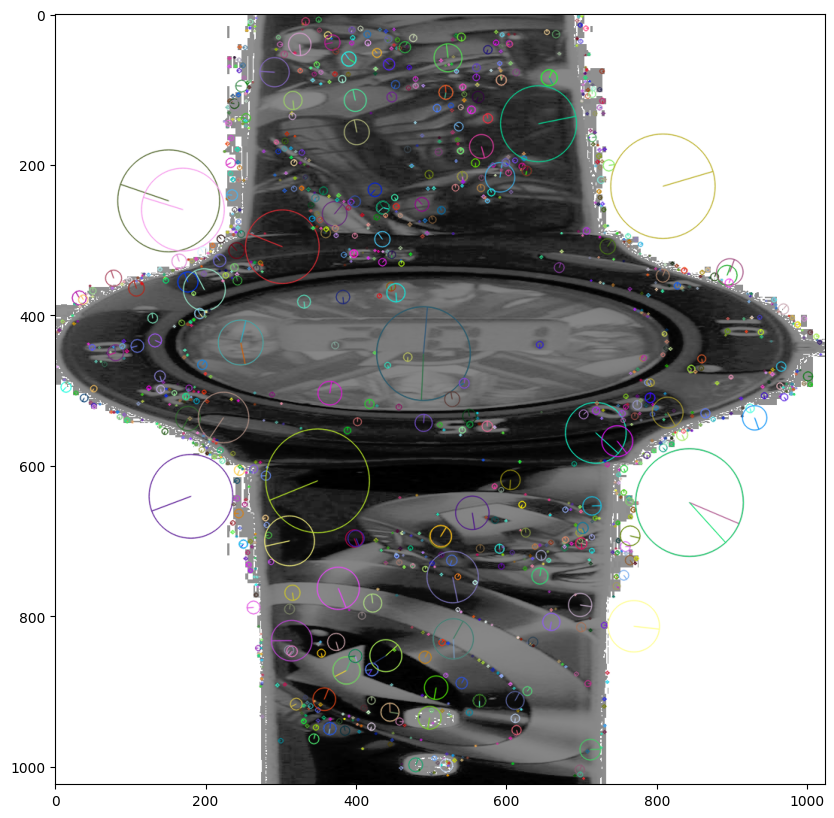

Le nombre de descripteurs pour la méthode SIFT est de :  (1455, 128)


In [49]:
# Création du modèle SIFT
sift = cv2.SIFT_create()

# Chargement de l'image (convertion en niveaux de gris)
image = cv2.imread(data_image.image[30], 0)

# Égalisation d'histogramme
image = cv2.equalizeHist(image)

# Détection des points clés et extraction des descripteurs
kp, des = sift.detectAndCompute(image, None)

# Dessiner les points clés sur l'image
img = cv2.drawKeypoints(image, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Afficher l'image avec les points clés
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()

# Afficher le nombre de descripteurs
print("Le nombre de descripteurs pour la méthode SIFT est de : ", des.shape)


___
- Le premier chiffre correspond aux nombres de point clé détéctés dans l'image par l'algorithme SIFT.
- Le second indique la dimension de chaque descripteur associé à un point clé
___
Un grand nombre de point clé signifie que l'image contient de nombreuses zone riches en caractéristiques.    
Chaque descripteurs est un vecteur de 128 valeurs (float), qui encore les caractéristiques visuelles autour d'un point clé.    
Ces valeurs décrivent la direction, l'orientation et l'intensité des gradients dans une zone atour du point clé.    
Le descripteur divise une région autour du point clé en une grille de 4x4 sous régions.    
Ces sous régions contiennent un histogramme de 8 orientations de gradient la formule est donc : 4 x 4 x 8 = 128 dimensions
___

## ORB

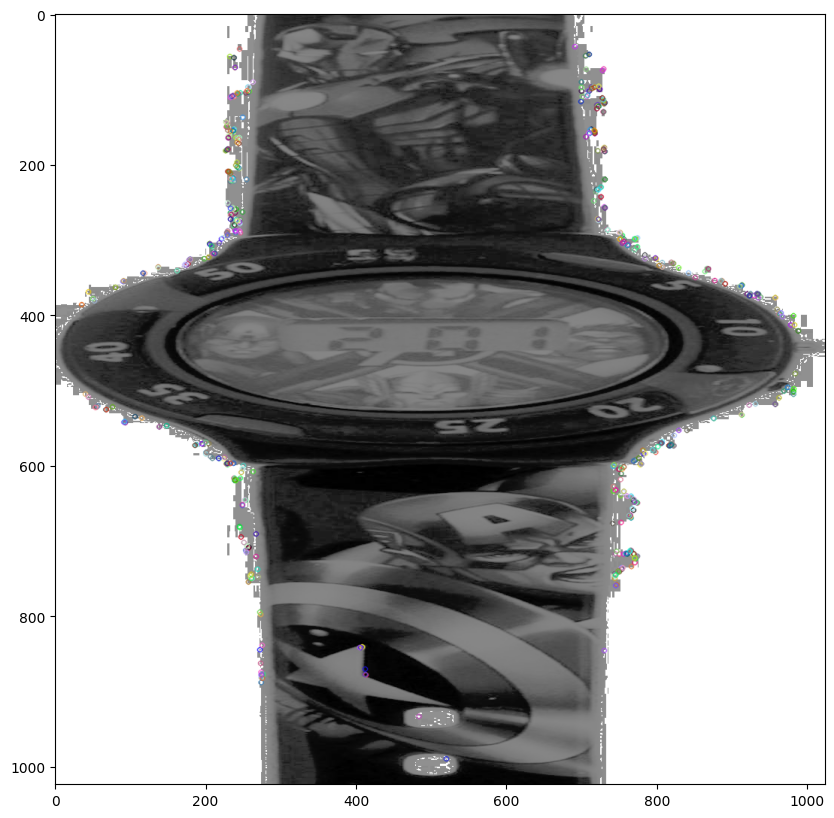

Le nombre de descripteurs pour la méthode ORB est de :  (500, 32)


In [50]:
orb = cv2.ORB_create()

# convertir en niveaux de gris
image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
image = cv2.imread(data_image.image[30],0)

image = cv2.equalizeHist(image)

# Création des points de détection des images
kp = orb.detect(image, None)
kp, des = orb.compute(image, kp)
img=cv2.drawKeypoints(image,kp,image)


# Représentation graphique
plt.figure(figsize = (10,10))
plt.imshow(img)
plt.show()
print("Le nombre de descripteurs pour la méthode ORB est de : ", des.shape)

___
- 500 représente le nombre total de point clé détéctés par l'algorithme ORB dans cette image.
- 32 est la dimension de chaque descripteur généré par ORB
___
L'algorithme a trouver 500 zone distinct dans l'image qui sont jugées pertinantes pour décrire son visuel.    
Contrairement a SIFT, ou les descripteurs sont des vecteurs floattants de 128 dimensions, les descripteurs ORB sont binaire et on une taille fixé a 32 octets.    
Chaque descripteurs encode des informations locales autours d'un point clé sous la forme d'un vecteur binaire en utilisant une methode appelée BRIEF. (Binary Robust Independent Elementary Features)    
BRIEF effectue des comparaison d'intensité entre des paires de pixels dans une petite zone autour du point clé.    
Chaque comparaison produit un bit (0 ou 1).    
ORB effectue 256 comparaison pour chaque point clé, ce qui génère un vecteur bineaire de 256 bits et ce vecteur est stocké dans les 32 octets. (256 ÷ 8 = 32)
___

In [51]:
sift_keypoints = []
temps1 = time.time()

# Utiliser cv2.SIFT_create()
sift = cv2.SIFT_create()

for image_num in range(data_image.shape[0]):
    # Charger l'image en niveaux de gris
    image = cv2.imread(data_image.image.iloc[image_num], 0)

    # Redimensionner l'image
    scale = 0.5  # 50% de l'image originale
    width = int(image.shape[1] * scale)
    height = int(image.shape[0] * scale)
    dim = (width, height)
    image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    # Égalisation d'histogramme
    res = cv2.equalizeHist(image)
    del image

    # Détection des points clés et calcul des descripteurs
    kp, des = sift.detectAndCompute(res, None)
    del res

    # Ajouter descripteurs valides
    if des is not None:
        sift_keypoints.append(des)
    del kp, des

# Créer une liste de descripteurs
sift_keypoints_by_img = sift_keypoints  # Liste des descripteurs par image
sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)  # Tous les descripteurs

print("Nombre de descripteurs : ", sift_keypoints_all.shape)
duration1 = time.time() - temps1
print("Le délai de traitement pour le SIFT est de : ", "%15.2f" % duration1, "secondes")

# Sélection du nombre de clusters
temps2 = time.time()
k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering avec MiniBatchKMeans
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3 * k, random_state=77)
kmeans.fit(sift_keypoints_all)
duration2 = time.time() - temps2
print("Le délai de traitement pour le KMeans est de : ", "%15.2f" % duration2, "secondes")

Nombre de descripteurs :  (1295013, 128)
Le délai de traitement pour le SIFT est de :            25.83 secondes
Nombre de clusters estimés :  1138
Création de 1138 clusters de descripteurs ...
Le délai de traitement pour le KMeans est de :            22.67 secondes


In [52]:
temps2 = time.time()

# Initialisation du vecteur pour stocker les histogrammes
histo_vect = []

# Parcourir chaque image et ses descripteurs
for i, image_desc in enumerate(sift_keypoints_by_img):
    if i % 100 == 0:
        print(i)

    # Initialisation de l'histogramme
    hist = np.zeros(len(kmeans.cluster_centers_))

    # Vérification que les descripteurs existent
    nb_des = len(image_desc)
    if nb_des == 0:
        print("Problème histogramme image : ", i)
    else:
        # Calcul des clusters pour chaque descripteur
        res = kmeans.predict(image_desc)

        # Construction de l'histogramme
        for cluster_idx in res:
            hist[cluster_idx] += 1.0 / nb_des

    # Ajouter l'histogramme à la liste des caractéristiques
    histo_vect.append(hist)

# Conversion de la liste en tableau NumPy
im_features = np.asarray(histo_vect)

# Mesurer le temps d'exécution
duration2 = time.time() - temps2
print("Temps de création des histogrammes : ", "%15.2f" % duration2, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
Temps de création des histogrammes :             7.44 secondes


In [53]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components = 0.9)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 1138)
Dimensions dataset après réduction PCA :  (1050, 279)


In [54]:
tsne = manifold.TSNE(n_components=2, learning_rate=200, init="random", random_state=77)
X_tsne_sift = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=["tsne1", "tsne2"])
df_tsne["class"] = data_image["cat_label"]
print(df_tsne.shape)

(1050, 3)


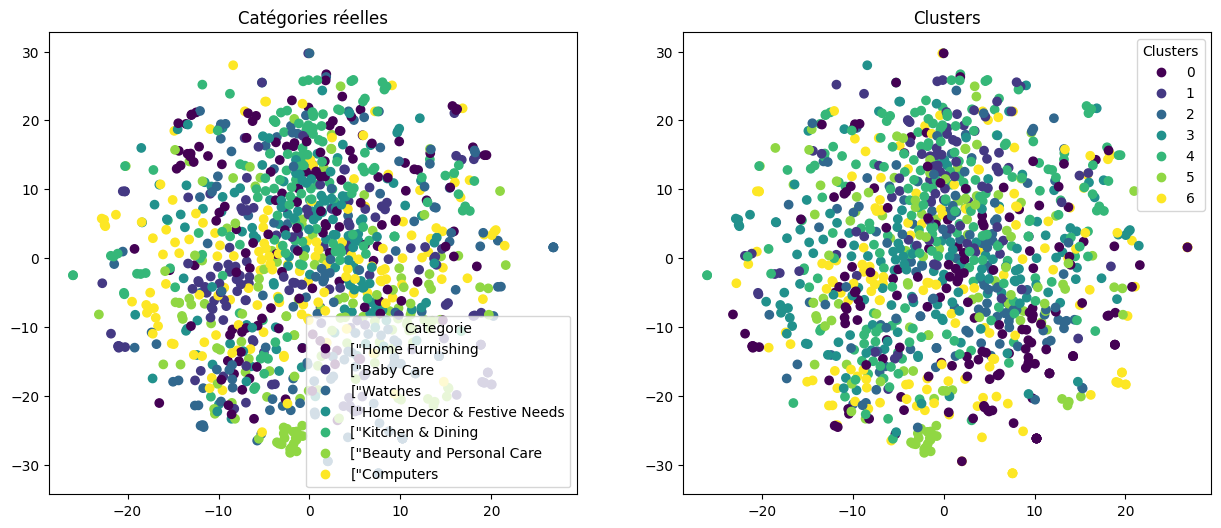

ARI :  0.4111


In [55]:
# Visualisation des clusters
visuel_tsne(X_tsne_sift, y_feature, labels, ARI)

## VGG16

In [56]:
"""# Chemin du dossier contenant les images
image_folder = "C:\\Users\\icema\\OpenClassrooms\\AI_Engineer\\.venv6\\Images"

# Création de la liste des chemins complets pour les images
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".jpg")]

# Conversion en DataFrame
data_image = pd.DataFrame({"image": image_paths})

# Chargement du modèle VGG16 pré-entraîné
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Ajout des couches personnalisées : Pooling, RELU, Dropout, Softmax
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling global
x = Dense(256, activation="relu")(x)  # Activation RELU
x = Dropout(0.5)(x)  # Dropout pour éviter le sur-apprentissage
output = Dense(10, activation="softmax")(x)  # Couches Softmax pour une classification (10 classes par exemple)

# Création du modèle final
#model = Model(inputs=base_model.inputs, outputs=output)
model = Model(inputs=base_model.input, outputs=output)  # TEST avec 'input' au lieu de 'inputs'

# Extraction des caractéristiques des images
vect = []

for image_num in range(data_image.shape[0]):
    # Chargement et prétraitement de l'image
    image_path = data_image.image.iloc[image_num]
    if not os.path.exists(image_path):
        print(f"Fichier introuvable : {image_path}")
        continue

    image = load_img(image_path, target_size=(224, 224))  # Mise à l'échelle correcte
    print(f"Image chargée : {image_path}")
    print(f"Dimensions avant conversion : {image.size}")

    image = img_to_array(image)  # Conversion en tableau
    print(f"Dimensions après conversion : {image.shape}")

    image = preprocess_input(image)  # Prétraitement spécifique à VGG
    print(f"Dimensions après prétraitement : {image.shape}")

    image = image.reshape((1, 224, 224, 3))  # Vérifiez que cette étape est correcte
    print(f"Dimensions finales pour le modèle : {image.shape}")

    # Prédiction pour extraire les caractéristiques
    features = model.predict(image)
    print(features.shape)  # Affichage de la forme des caractéristiques extraites
    vect.append(features[0])

# Conversion des vecteurs en DataFrame
im_feat_cnn = pd.DataFrame(vect)

# Calcul du temps de traitement
temps1 = time.time()
duration3 = time.time() - temps1
print("Temps de traitement KMeans :", "%15.2f" % duration3, "secondes")"""

'# Chemin du dossier contenant les images\nimage_folder = "C:\\Users\\icema\\OpenClassrooms\\AI_Engineer\\.venv6\\Images"\n\n# Création de la liste des chemins complets pour les images\nimage_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(".jpg")]\n\n# Conversion en DataFrame\ndata_image = pd.DataFrame({"image": image_paths})\n\n# Chargement du modèle VGG16 pré-entraîné\nbase_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))\n\n# Ajout des couches personnalisées : Pooling, RELU, Dropout, Softmax\nx = base_model.output\nx = GlobalAveragePooling2D()(x)  # Pooling global\nx = Dense(256, activation="relu")(x)  # Activation RELU\nx = Dropout(0.5)(x)  # Dropout pour éviter le sur-apprentissage\noutput = Dense(10, activation="softmax")(x)  # Couches Softmax pour une classification (10 classes par exemple)\n\n# Création du modèle final\n#model = Model(inputs=base_model.inputs, outputs=output)\nmodel = Model(inputs=base

In [57]:
"""print("Dataset avant PCA : ", im_feat_cnn.shape)
pca = decomposition.PCA(n_components=0.9)
feat_pca_cnn= pca.fit_transform(im_feat_cnn)
print("Dataset après PCA : ", feat_pca_cnn.shape)

ARI_cnn, X_tsne_cnn, labels_cnn = fc_ari(feat_pca_cnn)

visuel_tsne(X_tsne_cnn, y_feature, labels_cnn, ARI_cnn)"""

'print("Dataset avant PCA : ", im_feat_cnn.shape)\npca = decomposition.PCA(n_components=0.9)\nfeat_pca_cnn= pca.fit_transform(im_feat_cnn)\nprint("Dataset après PCA : ", feat_pca_cnn.shape)\n\nARI_cnn, X_tsne_cnn, labels_cnn = fc_ari(feat_pca_cnn)\n\nvisuel_tsne(X_tsne_cnn, y_feature, labels_cnn, ARI_cnn)'

In [58]:
# Modèle pré-entrainé VGG16
model = VGG16()

# Suppression de l'avant dernière couche
model = Model(inputs=model.input, outputs=model.layers[-2].output)

# Initialisation de la liste et extraction des caractéristiques des images
vect = []

temps3=time.time()

for image_num in range(data_image.shape[0]):
    # Chargement et redimensionnement
    image = load_img(data_image.image.iloc[image_num], target_size=(224, 224))

    # Convertion en tableau numpy
    image = img_to_array(image)

    # ajout d'une dimension supplémentaire
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

    # prétraitement VGG16
    image = preprocess_input(image)

    # Prédiction pour extraire les caractéristiques
    features = model.predict(image)
    print(features.shape)
    vect.append(features[0])

    # Création du DF
    im_feat_cnn = pd.DataFrame(vect)

duration3=time.time()-temps3
print("temps de traitement kmeans : ", "%15.2f" % duration3, "secondes")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
(

Dataset avant PCA :  (1050, 4096)
Dataset après PCA :  (1050, 314)
ARI :  0.4812 Temps d'exécution :  1.0


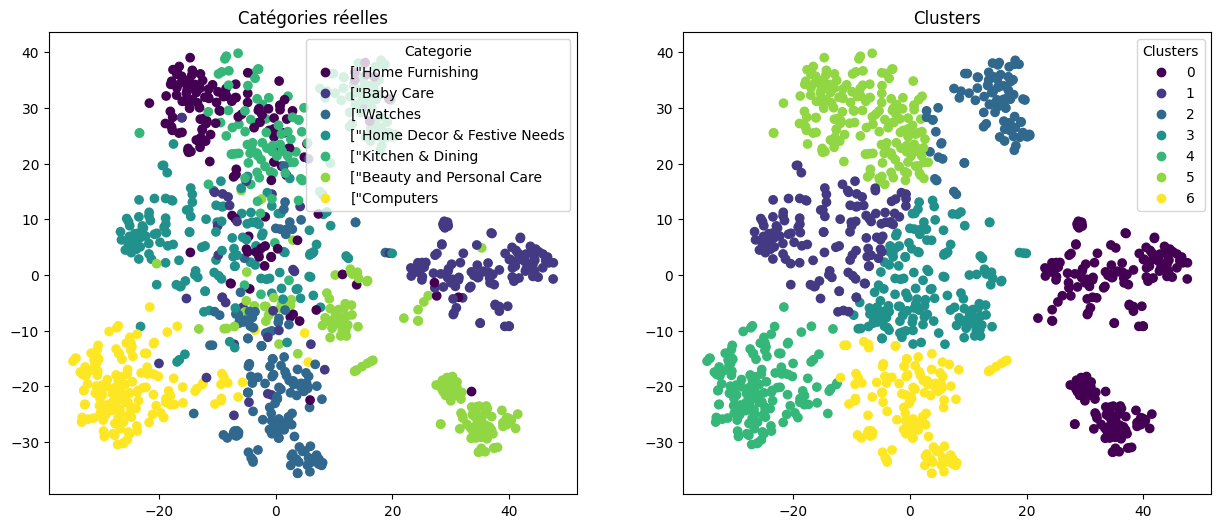

ARI :  0.4812


In [59]:
print("Dataset avant PCA : ", im_feat_cnn.shape)
pca = decomposition.PCA(n_components=0.9)
feat_pca_cnn= pca.fit_transform(im_feat_cnn)
print("Dataset après PCA : ", feat_pca_cnn.shape)

ARI_cnn, X_tsne_cnn, labels_cnn = fc_ari(feat_pca_cnn)

visuel_tsne(X_tsne_cnn, y_feature, labels_cnn, ARI_cnn)

## VGG19

In [60]:
# Modèle pré-entrainé VGG19
model = VGG19()

# Suppression de l'avant dernière couche
model = Model(inputs=model.input, outputs=model.layers[-2].output)

temps4=time.time()

# Initialisation de la liste et extraction des caractéristiques des images
vect = []
for image_num in range(data_image.shape[0]):
    # Chargement et redimensionnement
    image = load_img(data_image.image.iloc[image_num], target_size=(224, 224))
    # Convertion en tableau numpy
    image = img_to_array(image)
    # ajout d'une dimension supplémentaire
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prétraitement VGG19
    image = preprocess_input(image)

    # Prédiction pour extraire les caractéristiques
    features = model.predict(image)
    print(features.shape)
    vect.append(features[0])

    # Création du DF
    im_feat_cnn = pd.DataFrame(vect)

duration4=time.time()-temps4
print("temps de traitement kmeans : ", "%15.2f" % duration4, "secondes")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
(1, 4096)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
(

Dataset avant  PCA :  (1050, 4096)
Dataset après PCA :  (1050, 308)
ARI :  0.4391 Temps d'exécution :  2.0


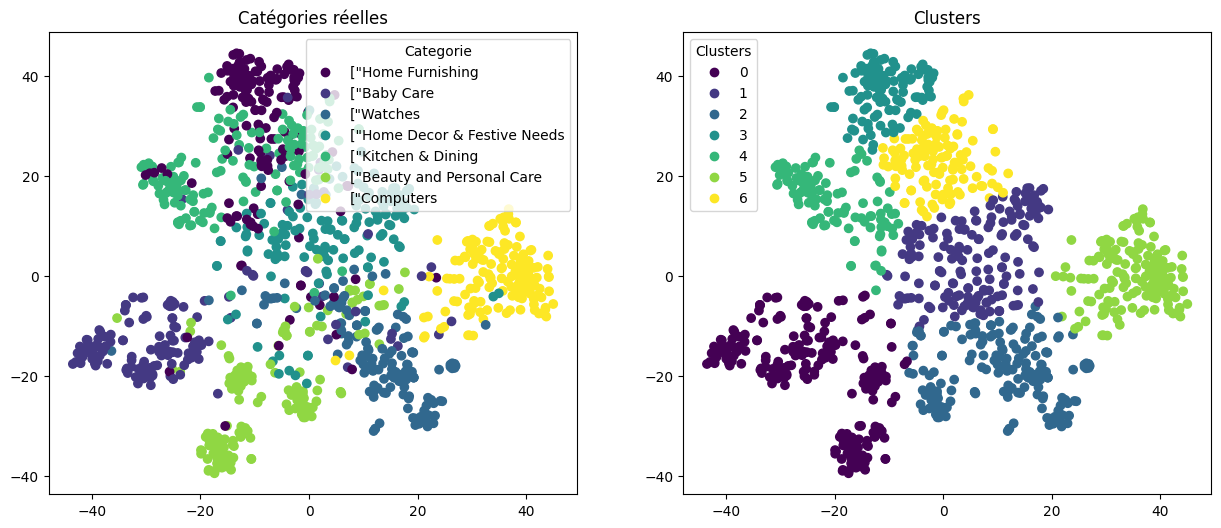

ARI :  0.4391


In [61]:
print("Dataset avant  PCA : ", im_feat_cnn.shape)
pca = decomposition.PCA(n_components=0.9)
feat_pca_cnn= pca.fit_transform(im_feat_cnn)
print("Dataset après PCA : ", feat_pca_cnn.shape)

ARI_cnn, X_tsne_cnn, labels_cnn = fc_ari(feat_pca_cnn)

visuel_tsne(X_tsne_cnn, y_feature, labels_cnn, ARI_cnn)